In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipy
from ipywidgets import IntProgress
import warnings
import time
import data_cleaning

warnings.filterwarnings("ignore")
pd.set_option('mode.copy_on_write', True)
plt.style.use('fivethirtyeight')

training_proportion = 11/16
psuedorandom = np.random.RandomState(42)
classify_df = data_cleaning.load_all_data(show_films=False)
predict_category = "Oscar-win"
predict_outcome = 1

##### CLASSIFIER CODE #####

def calculate_distance(row1, row2, idx, idx2=None):
    point1 = np.array(row1[idx:idx2])
    point2 = np.array(row2[idx:idx2])
    return np.sqrt(np.sum((point1 - point2)**2))

def nearest_neighbours_classifier(row, k=5, predict=predict_category, ideal_outcome=predict_outcome, return_pvalue=False):
    global training_data
    idx = row.index.get_loc(predict)+1
    distances = training_data.apply(calculate_distance, axis=1, row2=row, idx=idx)
    index = distances.sort_values().index
    sorted = training_data.loc[index]
    neighbours = sorted[:k]
    
    counted = neighbours[predict].value_counts().sort_values(ascending=False)
    classified = counted.index[0]
    
    if return_pvalue:
        if classified == ideal_outcome:
            p = counted.iloc[0] / k
        else:
            p = 1 - (counted.iloc[0] / k)
        return classified, p
    else:
        return classified

##### SAMPLING AND TESTING CODE #####

def sample(df, category="all", win=True):
    global training_data

    if category != "all":
       df = df[df["Type"] == category]
    
    shuffled = df.sample(frac=1, random_state=psuedorandom)
    n_train = int(len(shuffled) * training_proportion)
    training_data = shuffled.iloc[:n_train]
    test_data = shuffled.iloc[n_train:]

    if win:
        test_data = test_data[test_data["Oscar-win"] == 1]
    return test_data

def test(data, k=5, output=False, predict="Oscar-win"): # tests a set of data with the classifier
    results = []
    
    for i in range(len(data)):
        row = data.iloc[i]
        real_value = row[predict]
        test_value = nearest_neighbours_classifier(row, k=k, predict=predict)
        test_result = real_value == test_value
        results.append(test_result)
        if output: print("Real:\t", real_value, "\tPredicted:\t", test_value)
            
    proportion = (np.count_nonzero(results) / len(results))
    if output: print("Proportion of successful tests:", proportion)    
    return proportion


In [71]:
##### TEST 1 - HOW ACCURATELY CAN THE MODEL PREDICT OSCAR WINNERS FOR EACH CATEGORY? #####

n_trials = 1000
k = 5
test_only_winners = True
output = False
show_lengths = False

results = pd.Series([np.zeros(n_trials), np.zeros(n_trials), np.zeros(n_trials), np.zeros(n_trials)])
results.index = ["all", "film", "actress", "actor"]
lengths = pd.Series([np.zeros(n_trials), np.zeros(n_trials), np.zeros(n_trials), np.zeros(n_trials)])
lengths.index = ["all", "film", "actress", "actor"]

if test_only_winners:
    speed = 0.9
else:
    speed = 5.4
    
starttime = time.time()
expectedtime = int(n_trials * speed)

print("Starting test; running {} trials, expected to take ~{}s".format(n_trials, expectedtime))
progress_bar = IntProgress(min=0, max=n_trials)
ipy.display(progress_bar)

for i in range(n_trials):
    test_all = sample(classify_df, "all", win=test_only_winners)
    results.loc["all"][i] = test(test_all, k=k, output=output)
    lengths.loc["all"][i] = len(test_all)
   
    test_films = sample(classify_df, "film", win=test_only_winners)
    results.loc["film"][i] = test(test_films, k=k, output=output)
    lengths.loc["film"][i] = len(test_films)

    test_actresses = sample(classify_df, "actress", win=test_only_winners)
    results.loc["actress"][i] = test(test_actresses, k=k, output=output)
    lengths.loc["actress"][i] = len(test_actresses)

    test_actors = sample(classify_df, "actor", win=test_only_winners)
    results.loc["actor"][i] = test(test_actors, k=k, output=output)
    lengths.loc["actor"][i] = len(test_actors)

    progress_bar.value += 1

stoptime = time.time()
time_taken = round((stoptime - starttime), 1)

print("\nMean proportions of correctly-classified winners:", end="")
mean_results = []

for i in results.index:
    mean = results.loc[i].mean().round(2)
    mean_results.append(mean)
    print("\n\t{}: {}".format(i, mean), end="")
    if show_lengths:
        mean_length = lengths.loc[i].mean().round(2)
        print("\t\t[mean length {}]".format(mean_length), end="")

print("\n\n[Time taken: {} seconds]".format(n_trials, time_taken))
if output: print("Against an expected time of {} seconds".format(expectedtime))

Starting test; running 10 trials, expected to take ~9s


IntProgress(value=0, max=10)


Mean proportions of correctly-classified winners:
	all: 0.5
	film: 0.26
	actress: 0.55
	actor: 0.53

[Time taken: 10 seconds]


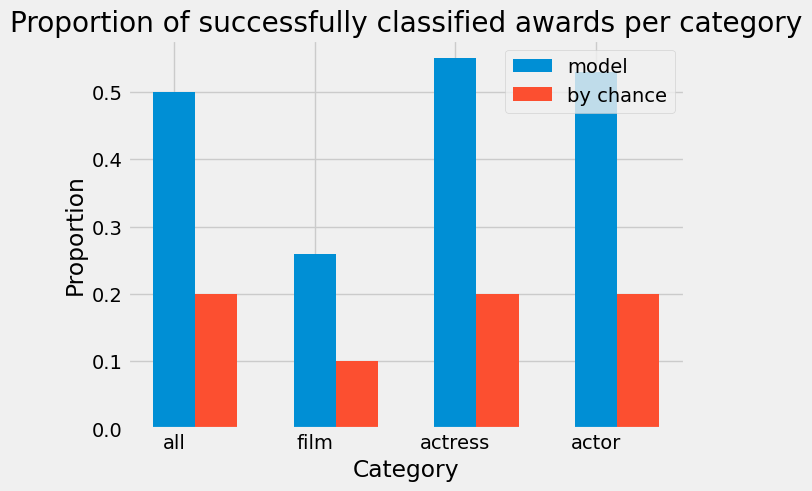

In [127]:
##### PLOTTING RESULTS FROM TEST 1 #####

by_chance = [0.2, 0.1, 0.2, 0.2]
width = 0.3
plt.bar(np.arange(len(mean_results)), mean_results, width=width)
plt.bar(np.arange(len(by_chance))+ width, by_chance, width=width)

plt.title('Proportion of successfully classified awards per category')
plt.legend(["model", "by chance"], loc="upper right")
plt.xticks(range(len(results)), results.index)
plt.xlabel('Category')
plt.ylabel('Proportion')

plt.show()

In [112]:
##### TEST 2 - HOW ACCURATELY DOES THE MODEL PREDICT OSCAR WINNERS FOR A EACH YEAR? #####

def test_year(year, output=False):
    global training_data
    
    if type(year) == str:
        year = pd.to_datetime(year)

    training_data = classify_df[classify_df["Year"] != year]
    test_data = classify_df[classify_df["Year"] == year]
    categories = ["film", "actress", "actor"]
    results = []
    
    if output: print("Predicted winners for {}".format(str(year)[4:]))
    
    for category in categories:
        nominees = test_data[test_data["Type"] == category]
        pvalues = np.zeros(len(nominees))
        multiple_winners = ""
        
        for i in range(len(nominees)):
            result, p = nearest_neighbours_classifier(nominees.iloc[i], return_pvalue=True)
            pvalues[i] = p
    
        idx = np.argwhere(pvalues == np.max(pvalues)).flatten()
        top_values = nominees.iloc[idx]["Name"].values
        
        if pvalues[idx][0] > 0:
            if len(top_values) > 1:
                predicted_winner = " / ".join(top_values)
                multiple_winners = " [predicted to win with same probability]"
            else:
                predicted_winner = top_values[0]
            
            if output: print("\tBest {}: {}{}".format(category, predicted_winner, multiple_winners))
            real_winner = nominees[nominees["Oscar-win"] == 1]["Name"].values[0]
            
            if real_winner == predicted_winner:
                if output: print("Predicted correctly")
                test_result = 1
            elif real_winner in predicted_winner:
                if output: print("Real winner was one of the predicted ones")
                test_result = 0.5
            else:
                if output: print("Incorrect")
                test_result = 0
                
        else:
            if output: print("\tBest {}: NO PREDICTION\t[not enough data]".format(category))
            test_result = 0
            
        results.append(test_result)

    mean = np.array(results).mean().round(2)
    return mean, results

year_range = pd.date_range(start=pd.to_datetime("2000"), periods=25, freq="YS")
all_proportions_over_time = []
mean_proportion_per_year = []

for i in year_range:
    p, proportions_from_year = test_year(i)
    mean_proportion_per_year.append(p)
    all_proportions_over_time += proportions_from_year    

proportion = np.array(all_proportions_over_time).mean().round(2)

print("Proportion of awards predicted successfully: {}\n[When given the nominees on a year-by-year basis]".format(proportion))


Proportion of awards predicted successfully: 0.63
[When given the nominees on a year-by-year basis]


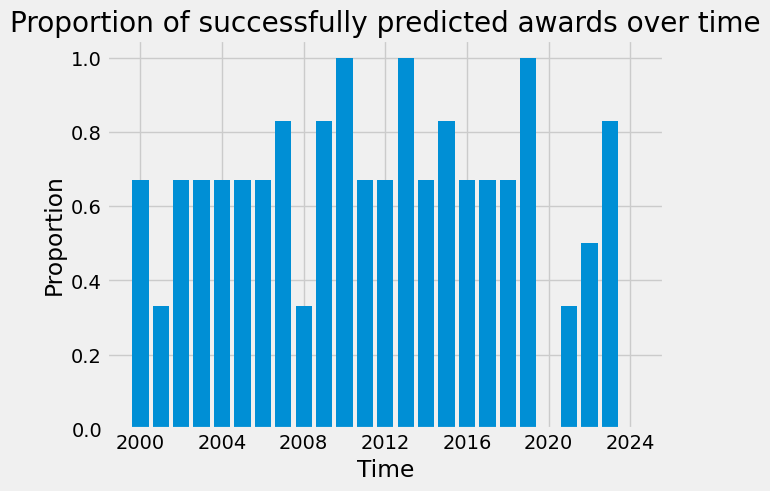

In [113]:
##### PLOTTING RESULTS FROM TEST 2 #####

plt.bar(year_range.strftime('%Y'), mean_proportion_per_year)
plt.title("Proportion of successfully predicted awards over time")
plt.xlabel("Time")
plt.ylabel("Proportion")

# adjust labels on the x-axis so the graph is readable
values, labels = plt.xticks()
new = [[], []]
for i in range(0, len(values), 4):
    new[0].append(values[i])
    new[1].append(labels[i])
plt.xticks(new[0], new[1])

plt.show()